# Default of Credit Card Clients Prediction: Tabular Foundation Models vs. Tree-Based Methods

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
hf_token = os.getenv("HFTOKEN")

Shape: (30000, 24)
Columns: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']

Dtypes:
 LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                   

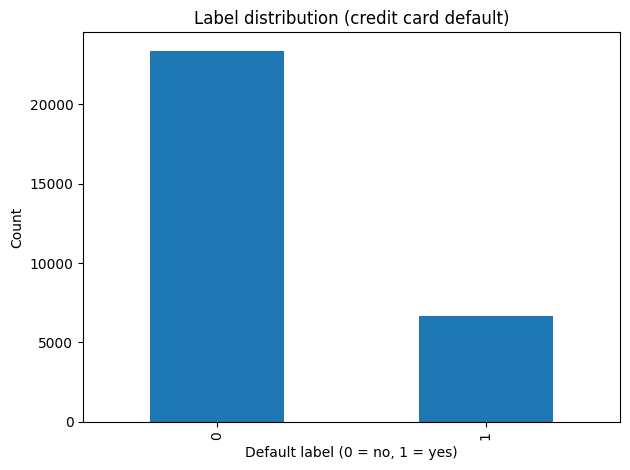

In [2]:
import os
import inspect
import time
import torch, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

from tabpfn import TabPFNClassifier
from tabicl import TabICLClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

path = "./data/default of credit card clients.xlsx"
fname = os.path.basename(path).lower()
dataset_label = "credit card default"

# In the original UCI file, row 0 is X1..X23,Y and row 1 is the real header.
df = pd.read_excel(path, sheet_name=0, header=1, engine="openpyxl")
df.columns = [str(c).strip() for c in df.columns]

df = df.dropna(axis=1, how="all")
df = df.drop(columns=["ID"], errors="ignore")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 60)

print("\nHead:\n", df.head())
print("\nSummary stats:\n", df.describe(include="all").T)

# Define target + features
target_col = "default payment next month"

X = df.drop(columns=[target_col, "ID"], errors="ignore")
y = df[target_col].astype(int)

y_counts = y.value_counts().sort_index()
print(f"\nTarget column: {target_col}")
print("\nDefault label counts:\n", y_counts)

plt.figure()
y_counts.plot(kind="bar")
plt.xlabel("Default label (0 = no, 1 = yes)")
plt.ylabel("Count")
plt.title(f"Label distribution ({dataset_label})")
plt.tight_layout()
plt.show()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


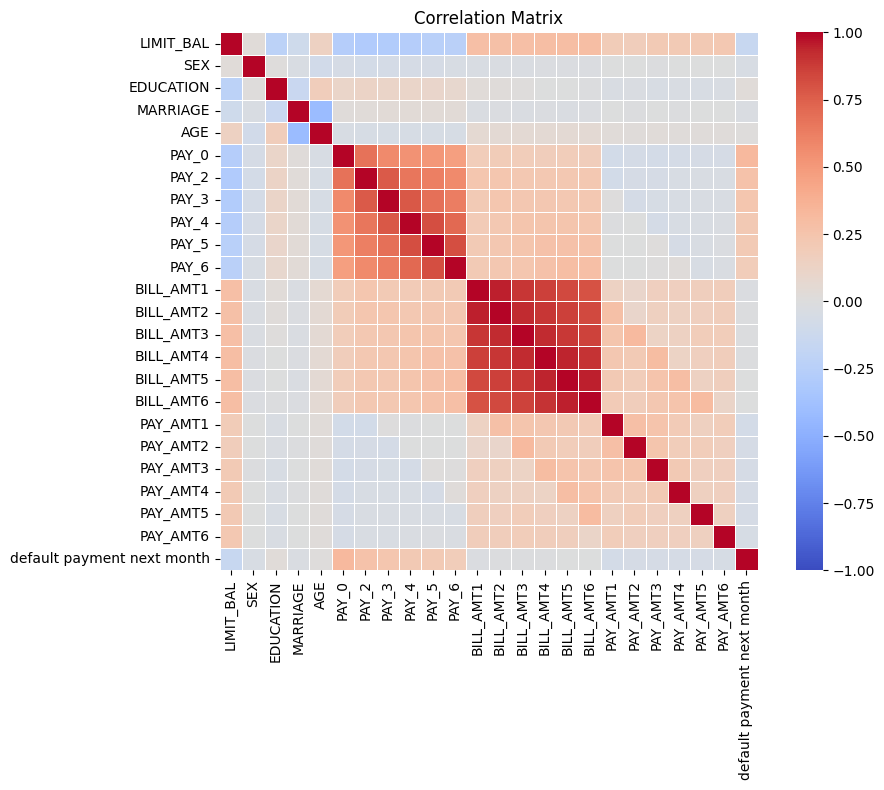

In [3]:

corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    vmin=-1, vmax=1,
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Plot Function

In [4]:
def plot_model_results(model_name):
    res = MODEL_RESULTS[model_name]
    cv_metrics_df = res["cv_metrics_df"]
    y_true_cv = res["y_true_cv"]
    y_pred_cv = res["y_pred_cv"]
    y_proba_cv = res["y_proba_cv"]
    dataset = res.get("dataset", "unknown dataset")

    # CV metrics box/strip
    metrics_long = cv_metrics_df.melt(
        id_vars=["fold"],
        value_vars=["acc", "auc"],
        var_name="metric",
        value_name="value",
    )
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=metrics_long, x="metric", y="value")
    sns.stripplot(data=metrics_long, x="metric", y="value", jitter=True, size=5)
    plt.title(f"{model_name} ({dataset}): CV metrics across folds")
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_true_cv, y_pred_cv, labels=[0, 1])
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} ({dataset}): Confusion matrix (pooled)")
    plt.tight_layout()
    plt.show()

    # ROC
    if len(np.unique(y_true_cv)) == 2:
        fpr, tpr, _ = roc_curve(y_true_cv, y_proba_cv)
        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.title(f"{model_name} ({dataset}): ROC curve (pooled)")
        plt.tight_layout()
        plt.show()

    # Precision–Recall
    prec, rec, _ = precision_recall_curve(y_true_cv, y_proba_cv)
    ap = average_precision_score(y_true_cv, y_proba_cv)
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} ({dataset}): Precision–Recall curve (AP={ap:.3f})")
    plt.tight_layout()
    plt.show()

    # Reliability curve (simple binned calibration)
    bins = np.linspace(0.0, 1.0, 11)
    bin_ids = np.digitize(y_proba_cv, bins) - 1

    bin_centers, frac_pos = [], []
    for b in range(len(bins) - 1):
        m = bin_ids == b
        if m.sum() == 0:
            continue
        bin_centers.append((bins[b] + bins[b + 1]) / 2)
        frac_pos.append(y_true_cv[m].mean())

    plt.figure(figsize=(5, 4))
    plt.plot(bin_centers, frac_pos, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Predicted probability (bin center)")
    plt.ylabel("Empirical P(y=1)")
    plt.title(f"{model_name} ({dataset}): Reliability curve (pooled)")
    plt.tight_layout()
    plt.show()


### TabPFN (Classifier)

In [12]:
COOLDOWN_S = 600 # To reduce thermal throttling when benchmarking timing

MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabpfn"

y_bin = y.astype(int)

p = float(y_bin.mean())
print("Positive rate (default=1):", p)
print("Majority baseline accuracy:", max(p, 1 - p))

# Use stratified CV
skf = cv

def get_pos_proba(model, X_):
    proba = model.predict_proba(X_)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

fold_summaries = []
all_y_true, all_y_pred, all_y_proba = [], [], []

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"
print("CUDA available:", use_cuda, "| device:", device)
if use_cuda:
    print("GPU:", torch.cuda.get_device_name(0))

warm_n = min(256, len(X))
warm_model = TabPFNClassifier(device=device)
_ = warm_model.fit(X.iloc[:warm_n], y_bin.iloc[:warm_n])
_ = get_pos_proba(warm_model, X.iloc[:warm_n])
if use_cuda:
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y_bin), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

    model = TabPFNClassifier(device=device)

    if use_cuda:
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if use_cuda:
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if use_cuda:
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    proba = get_pos_proba(model, X_te)
    if use_cuda:
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    y_hat = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, y_hat)
    auc = roc_auc_score(y_te, proba)

    fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(y_hat)
    all_y_proba.append(proba)

    print(f"Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

    del model
    gc.collect()
    if use_cuda:
        torch.cuda.empty_cache()

    # optional cool-down to reduce thermal throttling and get better benchmarks for timing
    if use_cuda and COOLDOWN_S > 0:
        time.sleep(COOLDOWN_S)

cv_metrics_df = pd.DataFrame(fold_summaries)
y_true_cv = np.concatenate(all_y_true)
y_pred_cv = np.concatenate(all_y_pred)
y_proba_cv = np.concatenate(all_y_proba)

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": cv_metrics_df,
    "y_true_cv": y_true_cv,
    "y_pred_cv": y_pred_cv,
    "y_proba_cv": y_proba_cv,
    "dataset": dataset_label,
}

print(
    f"\n{model_name} 5-fold CV: "
    f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
    f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
)
print(
    f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
    f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
)

Positive rate (default=1): 0.2212
Majority baseline accuracy: 0.7787999999999999
CUDA available: True | device: cuda
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Fold 1: ACC=0.8177 AUC=0.8015 | fit=0.976s pred=59.402s
Fold 2: ACC=0.8183 AUC=0.7832 | fit=1.363s pred=62.030s
Fold 3: ACC=0.8188 AUC=0.7872 | fit=1.464s pred=60.721s
Fold 4: ACC=0.8268 AUC=0.7918 | fit=1.570s pred=60.634s
Fold 5: ACC=0.8195 AUC=0.7848 | fit=1.657s pred=60.812s

tabpfn 5-fold CV: ACC=0.8202±0.0038, AUC=0.7897±0.0073
Timing: fit=1.41s±0.26, predict=60.72s±0.93


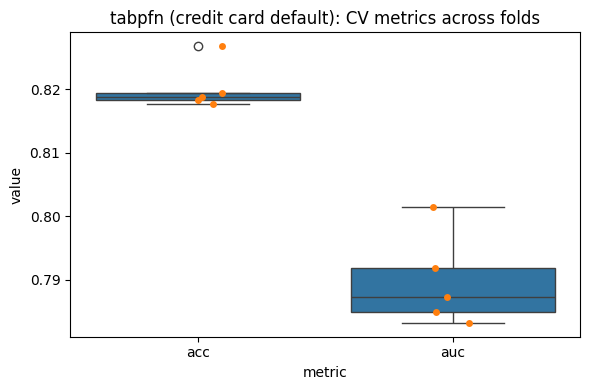

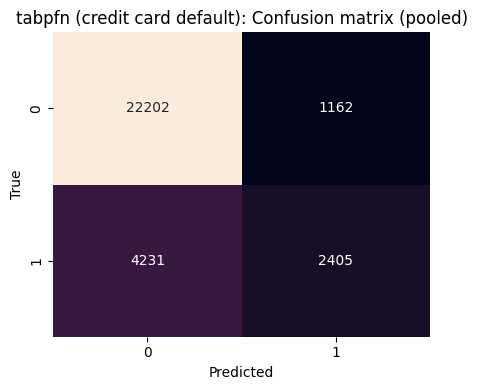

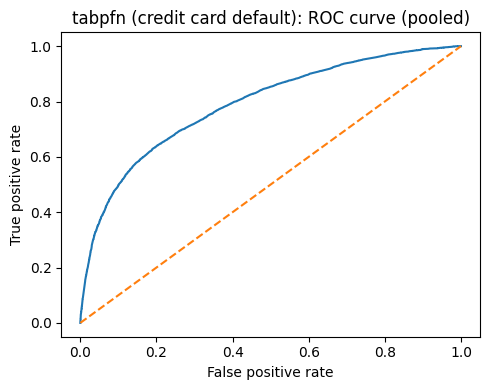

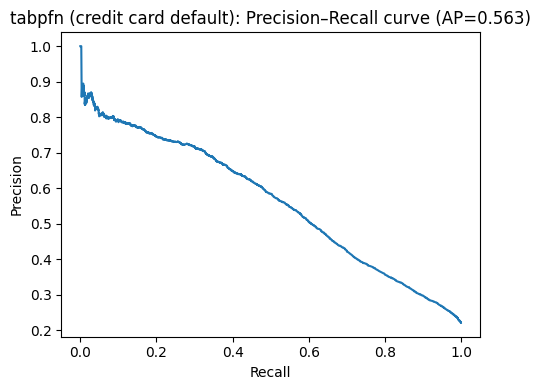

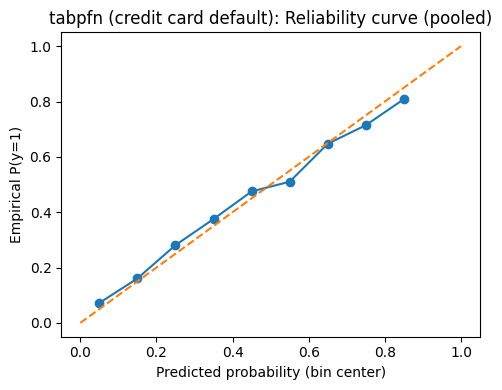

In [13]:
plot_model_results("tabpfn")

In [9]:
'''
# GPU diagnostics
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
torch.cuda.synchronize()

_ = model.predict_proba(X_te)
torch.cuda.synchronize()

alloc = torch.cuda.max_memory_allocated() / 1e9
resv  = torch.cuda.max_memory_reserved() / 1e9
curr_alloc = torch.cuda.memory_allocated() / 1e9
curr_resv  = torch.cuda.memory_reserved() / 1e9
print(f"peak allocated GB: {alloc:.3f}")
print(f"peak reserved  GB: {resv:.3f}")
print(f"current allocated GB: {curr_alloc:.3f}")
print(f"current reserved  GB: {curr_resv:.3f}")

del model
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
'''

'\n# GPU diagnostics\ntorch.cuda.reset_peak_memory_stats()\ntorch.cuda.empty_cache()\ntorch.cuda.synchronize()\n\n_ = model.predict_proba(X_te)\ntorch.cuda.synchronize()\n\nalloc = torch.cuda.max_memory_allocated() / 1e9\nresv  = torch.cuda.max_memory_reserved() / 1e9\ncurr_alloc = torch.cuda.memory_allocated() / 1e9\ncurr_resv  = torch.cuda.memory_reserved() / 1e9\nprint(f"peak allocated GB: {alloc:.3f}")\nprint(f"peak reserved  GB: {resv:.3f}")\nprint(f"current allocated GB: {curr_alloc:.3f}")\nprint(f"current reserved  GB: {curr_resv:.3f}")\n\ndel model\ngc.collect()\ntorch.cuda.empty_cache()\ntorch.cuda.synchronize()\n'

### TabICL

In [10]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabicl"

y_bin = y.astype(int)

p = float(y_bin.mean())
print("Positive rate (default=1):", p)
print("Majority baseline accuracy:", max(p, 1 - p))

# Use stratified CV
skf = cv

def get_pos_proba(model, X_):
    proba = model.predict_proba(X_)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

fold_summaries = []
all_y_true, all_y_pred, all_y_proba = [], [], []

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"
print("CUDA available:", use_cuda, "| device:", device)
if use_cuda:
    print("GPU:", torch.cuda.get_device_name(0))

warm_n = min(256, len(X))
warm_model = TabICLClassifier(device=device)
_ = warm_model.fit(X.iloc[:warm_n], y_bin.iloc[:warm_n])
_ = get_pos_proba(warm_model, X.iloc[:warm_n])
if use_cuda:
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y_bin), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

    model = TabICLClassifier(device=device)

    if use_cuda:
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if use_cuda:
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if use_cuda:
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    proba = get_pos_proba(model, X_te)
    if use_cuda:
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    y_hat = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, y_hat)
    auc = roc_auc_score(y_te, proba)

    fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(y_hat)
    all_y_proba.append(proba)

    print(f"Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

    del model
    gc.collect()
    if use_cuda:
        torch.cuda.empty_cache()

    # optional cool-down to reduce thermal throttling and get better benchmarks for timing
    if use_cuda and COOLDOWN_S > 0:
        time.sleep(COOLDOWN_S)

cv_metrics_df = pd.DataFrame(fold_summaries)
y_true_cv = np.concatenate(all_y_true)
y_pred_cv = np.concatenate(all_y_pred)
y_proba_cv = np.concatenate(all_y_proba)

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": cv_metrics_df,
    "y_true_cv": y_true_cv,
    "y_pred_cv": y_pred_cv,
    "y_proba_cv": y_proba_cv,
    "dataset": dataset_label,
}

print(
    f"\n{model_name} 5-fold CV: "
    f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
    f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
)
print(
    f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
    f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
)

Positive rate (default=1): 0.2212
Majority baseline accuracy: 0.7787999999999999
CUDA available: True | device: cuda
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Fold 1: ACC=0.8182 AUC=0.7979 | fit=0.917s pred=51.055s
Fold 2: ACC=0.8173 AUC=0.7813 | fit=1.099s pred=49.067s
Fold 3: ACC=0.8178 AUC=0.7870 | fit=1.097s pred=48.873s
Fold 4: ACC=0.8267 AUC=0.7903 | fit=1.116s pred=49.219s
Fold 5: ACC=0.8202 AUC=0.7840 | fit=0.969s pred=50.483s

tabicl 5-fold CV: ACC=0.8200±0.0039, AUC=0.7881±0.0064
Timing: fit=1.04s±0.09, predict=49.74s±0.97


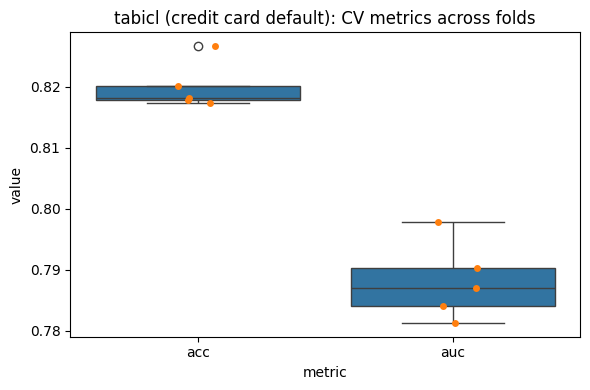

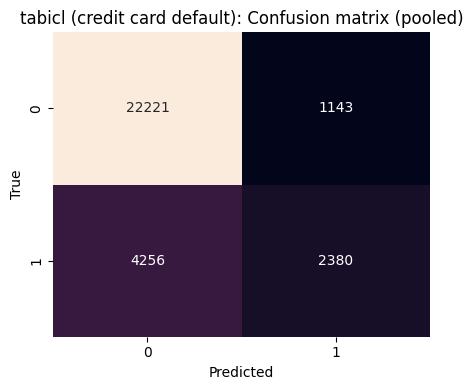

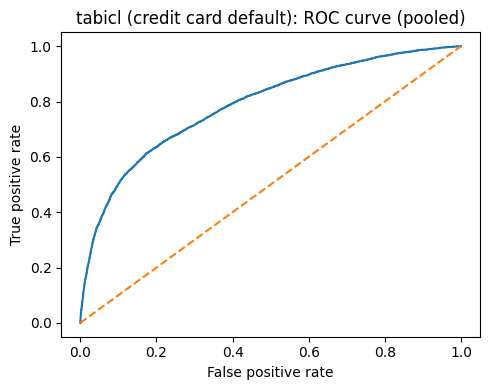

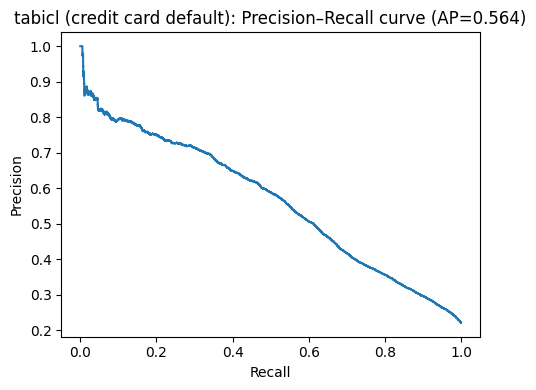

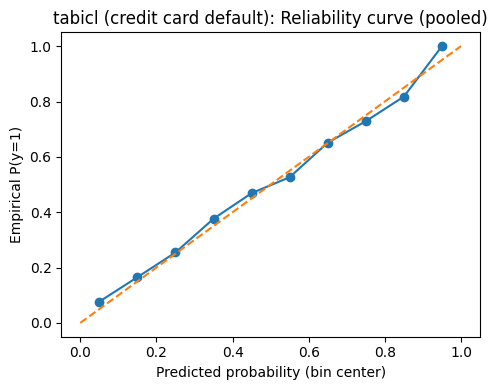

In [11]:
plot_model_results("tabicl")

### Random Forest, XGBoost, CatBoost and LightGBM

In [14]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

y_bin = y.astype(int)

p = float(y_bin.mean())
print("Positive rate (default=1):", p)
print("Majority baseline accuracy:", max(p, 1 - p))
print(55 * "-")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

def _get_pos_proba(model, X_te):
    proba = model.predict_proba(X_te)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

def run_cv(model_name, make_model):
    fold_summaries = []
    all_y_true, all_y_pred, all_y_proba = [], [], []

    warm_n = min(256, len(X))
    warm = make_model()
    warm.fit(X.iloc[:warm_n], y_bin.iloc[:warm_n])
    _ = _get_pos_proba(warm, X.iloc[:warm_n])

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y_bin), 1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

        model = make_model()

        t0 = time.perf_counter()
        model.fit(X_tr, y_tr)
        fit_s = time.perf_counter() - t0

        t0 = time.perf_counter()
        proba = _get_pos_proba(model, X_te)
        pred_s = time.perf_counter() - t0

        y_hat = (proba >= 0.5).astype(int)

        acc = accuracy_score(y_te, y_hat)
        auc = roc_auc_score(y_te, proba)

        fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
        all_y_true.append(y_te.to_numpy())
        all_y_pred.append(y_hat)
        all_y_proba.append(proba)

        print(f"{model_name} Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

    cv_metrics_df = pd.DataFrame(fold_summaries)
    y_true_cv = np.concatenate(all_y_true)
    y_pred_cv = np.concatenate(all_y_pred)
    y_proba_cv = np.concatenate(all_y_proba)

    MODEL_RESULTS[model_name] = {
        "cv_metrics_df": cv_metrics_df,
        "y_true_cv": y_true_cv,
        "y_pred_cv": y_pred_cv,
        "y_proba_cv": y_proba_cv,
        "dataset": dataset_label,
    }

    print(
        f"\n{model_name} 5-fold CV: "
        f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
        f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
    )
    print(
        f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
        f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
    )
    print(55 * "-")

models_to_run = {}

models_to_run["rf"] = lambda: RandomForestClassifier(
    n_estimators=500,
    random_state=20,
    n_jobs=-1,
)

models_to_run["xgb"] = lambda: XGBClassifier(
    random_state=20,
    n_jobs=-1,
    eval_metric="logloss",
)

models_to_run["cat"] = lambda: CatBoostClassifier(
    random_seed=20,
    verbose=False,
)

models_to_run["lgbm"] = lambda: LGBMClassifier(
    random_state=20,
    n_jobs=-1,
    verbose=-1,
)

for name, factory in models_to_run.items():
    run_cv(name, factory)


Positive rate (default=1): 0.2212
Majority baseline accuracy: 0.7787999999999999
-------------------------------------------------------
rf Fold 1: ACC=0.8208 AUC=0.7734 | fit=3.338s pred=0.162s
rf Fold 2: ACC=0.8197 AUC=0.7691 | fit=3.570s pred=0.150s
rf Fold 3: ACC=0.8188 AUC=0.7757 | fit=2.966s pred=0.150s
rf Fold 4: ACC=0.8180 AUC=0.7622 | fit=3.075s pred=0.127s
rf Fold 5: ACC=0.8110 AUC=0.7557 | fit=2.943s pred=0.117s

rf 5-fold CV: ACC=0.8177±0.0039, AUC=0.7672±0.0082
Timing: fit=3.18s±0.27, predict=0.14s±0.02
-------------------------------------------------------
xgb Fold 1: ACC=0.8188 AUC=0.7745 | fit=0.135s pred=0.006s
xgb Fold 2: ACC=0.8142 AUC=0.7604 | fit=0.128s pred=0.006s
xgb Fold 3: ACC=0.8158 AUC=0.7761 | fit=0.133s pred=0.006s
xgb Fold 4: ACC=0.8162 AUC=0.7611 | fit=0.137s pred=0.006s
xgb Fold 5: ACC=0.8085 AUC=0.7534 | fit=0.133s pred=0.005s

xgb 5-fold CV: ACC=0.8147±0.0038, AUC=0.7651±0.0098
Timing: fit=0.13s±0.00, predict=0.01s±0.00
-------------------------------

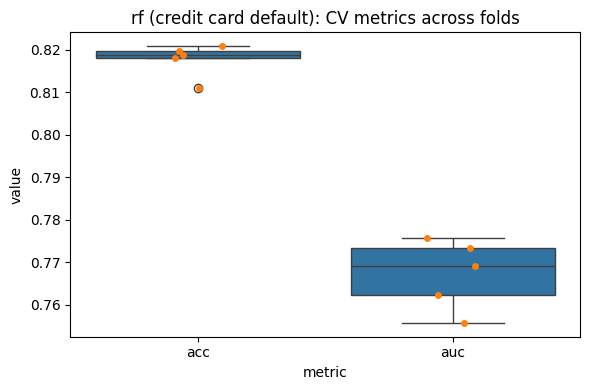

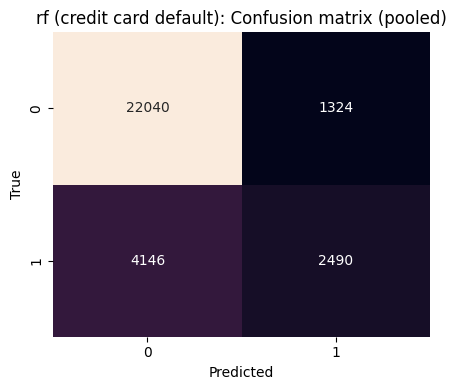

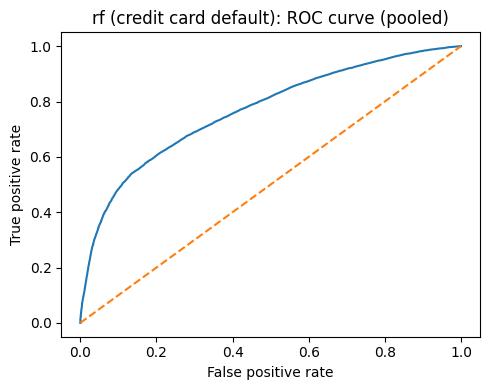

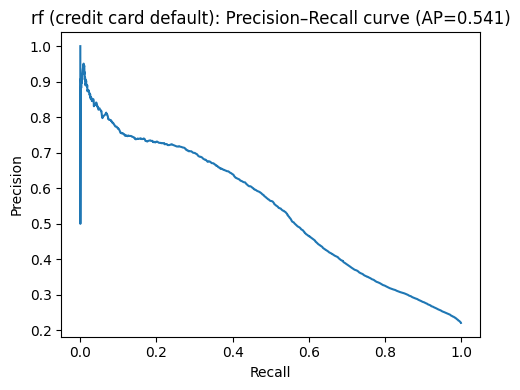

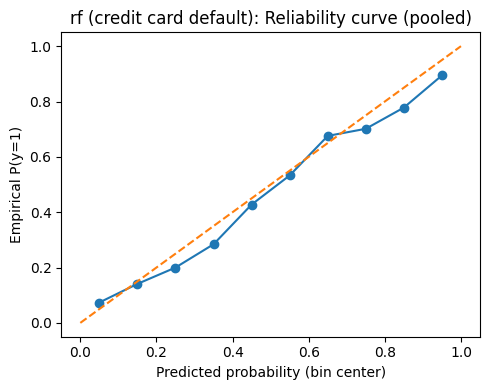

In [15]:
plot_model_results("rf")

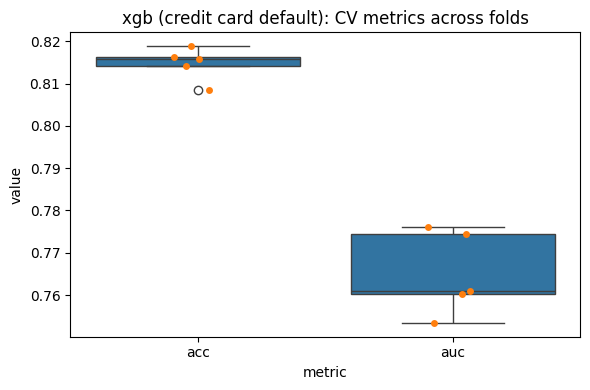

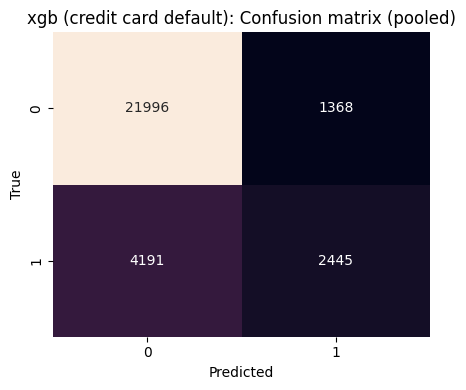

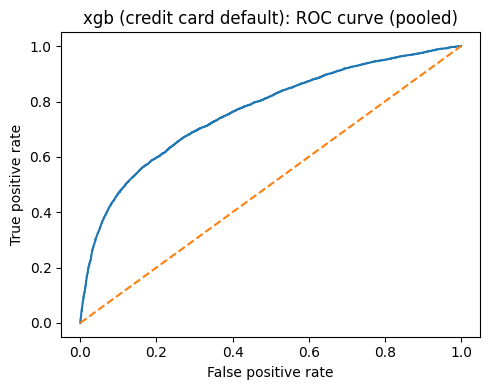

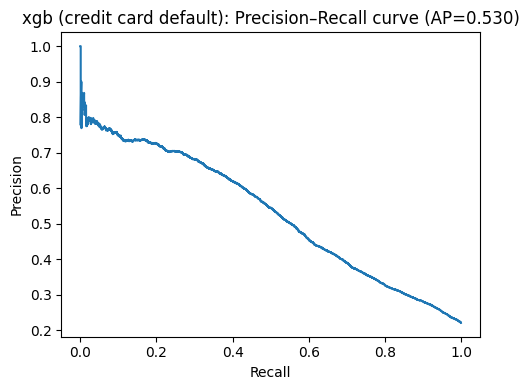

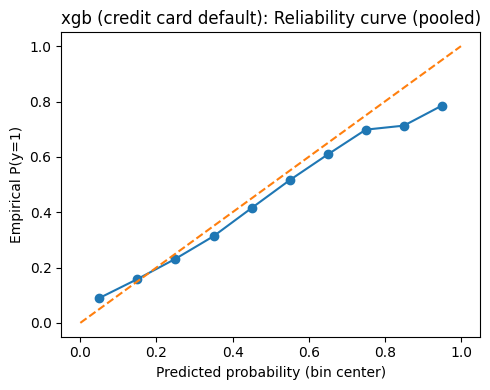

In [16]:
plot_model_results("xgb")

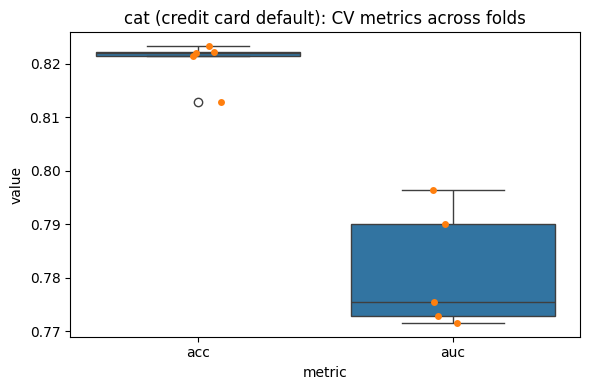

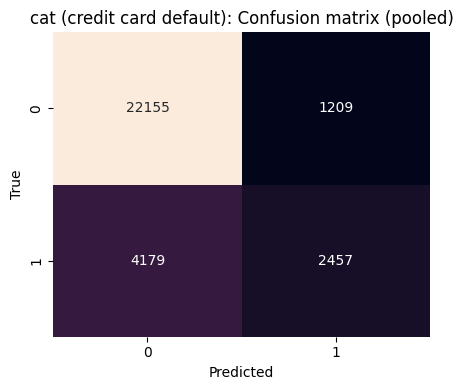

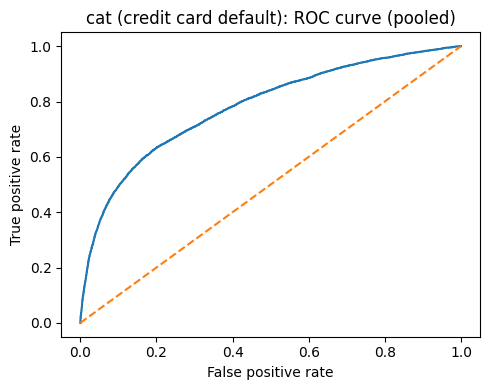

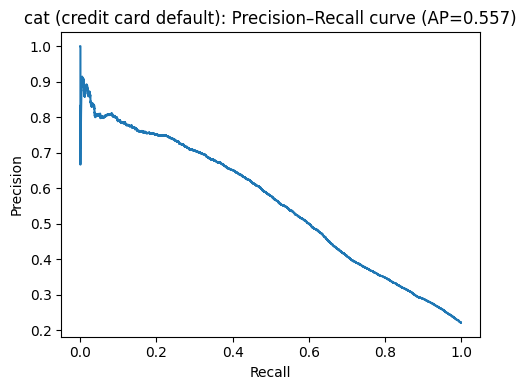

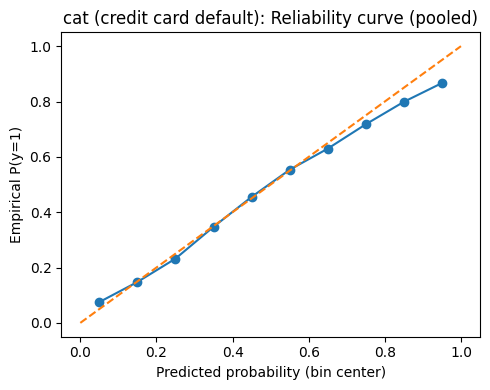

In [17]:
plot_model_results("cat")

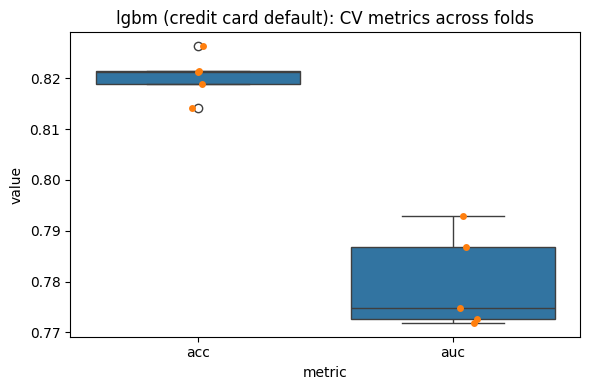

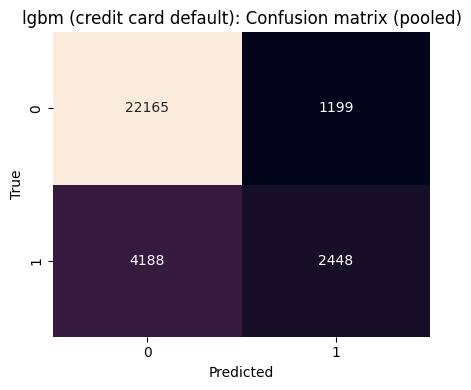

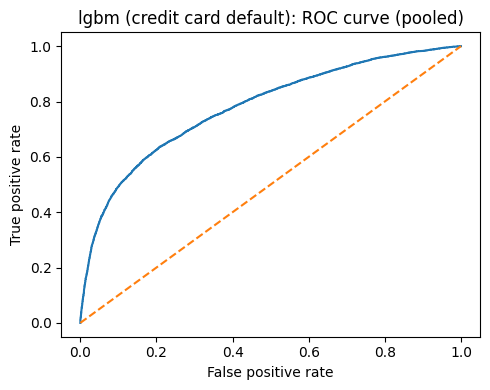

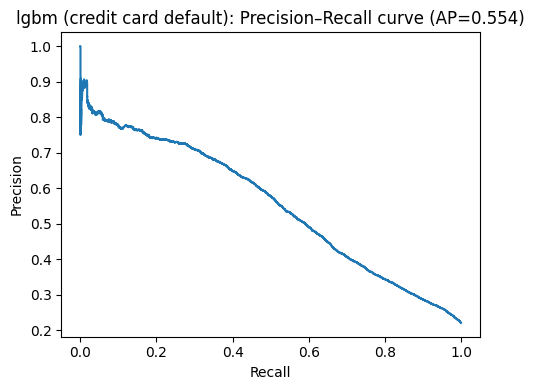

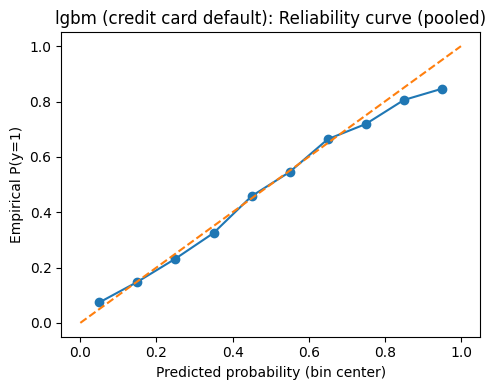

In [18]:
plot_model_results("lgbm")

In [19]:
rows = []
for name, res in MODEL_RESULTS.items():
    cv_df = res.get("cv_metrics_df", None)
    if cv_df is None or cv_df.empty:
        continue
    rows.append({
        "model": name,
        "acc_mean": cv_df["acc"].mean(),
        "acc_std": cv_df["acc"].std(ddof=1),
        "auc_mean": cv_df["auc"].mean(),
        "auc_std": cv_df["auc"].std(ddof=1),
        "fit_s_mean": cv_df["fit_s"].mean() if "fit_s" in cv_df.columns else None,
        "pred_s_mean": cv_df["pred_s"].mean() if "pred_s" in cv_df.columns else None,
        "n_folds": int(cv_df.shape[0]),
    })

summary_df = pd.DataFrame(rows).sort_values("auc_mean", ascending=False).reset_index(drop=True)

for c in ["acc_mean", "acc_std", "auc_mean", "auc_std", "fit_s_mean", "pred_s_mean"]:
    if c in summary_df.columns:
        summary_df[c] = summary_df[c].astype(float)

display(summary_df.style.format({
    "acc_mean": "{:.4f}",
    "acc_std": "{:.4f}",
    "auc_mean": "{:.4f}",
    "auc_std": "{:.4f}",
    "fit_s_mean": "{:.3f}",
    "pred_s_mean": "{:.3f}",
}))


,model,acc_mean,acc_std,auc_mean,auc_std,fit_s_mean,pred_s_mean,n_folds
0,tabpfn,0.8202,0.0038,0.7897,0.0073,1.406,60.720,5
1,tabicl,0.8200,0.0039,0.7881,0.0064,1.040,49.739,5
2,cat,0.8204,0.0043,0.7813,0.0112,7.072,0.006,5
3,lgbm,0.8204,0.0044,0.7798,0.0095,0.139,0.005,5
4,rf,0.8177,0.0039,0.7672,0.0082,3.179,0.141,5
5,xgb,0.8147,0.0038,0.7651,0.0098,0.133,0.006,5


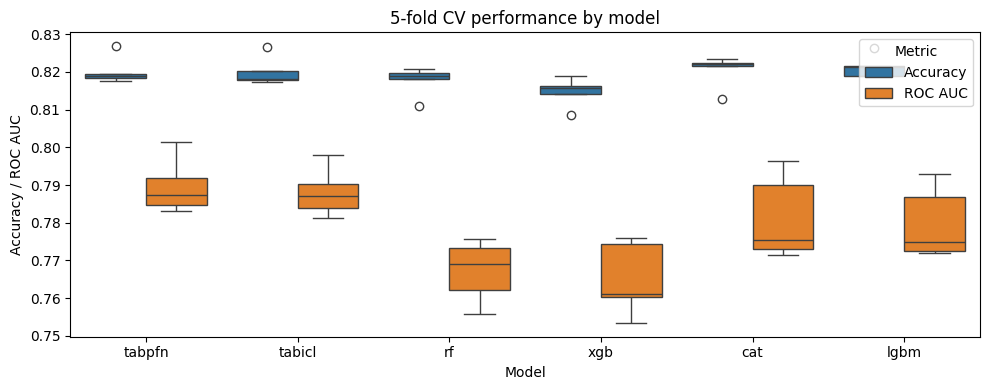

In [20]:
rows = []
for name, res in MODEL_RESULTS.items():
    cv_df = res.get("cv_metrics_df")
    if cv_df is None or cv_df.empty:
        continue
    tmp = cv_df.copy()
    tmp["model"] = name
    rows.append(tmp)

cv_all = pd.concat(rows, ignore_index=True)

m_long = cv_all.melt(
    id_vars=["model", "fold"],
    value_vars=["acc", "auc"],
    var_name="metric",
    value_name="value",
)

metric_names = {"acc": "Accuracy", "auc": "ROC AUC"}
m_long["metric"] = m_long["metric"].map(metric_names)

plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=m_long, x="model", y="value", hue="metric")

ax.set_xlabel("Model")
ax.set_ylabel("Accuracy / ROC AUC")
ax.set_title("5-fold CV performance by model")

ax.legend(title="Metric", loc="upper right", frameon=True)

plt.tight_layout()
plt.show()


### Optuna optimization

In [21]:
def _cv_auc_for_model(make_model, X, y_bin, skf, trial=None):
    aucs = []
    for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y_bin), 1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

        model = make_model()
        model.fit(X_tr, y_tr)
        proba = _get_pos_proba(model, X_te)
        auc = roc_auc_score(y_te, proba)
        aucs.append(auc)

        if trial is not None:
            trial.report(float(np.mean(aucs)), step=fold)
            if trial.should_prune():
                raise optuna.TrialPruned()

    return float(np.mean(aucs))

def _cv_auc_acc_for_model(make_model, X, y_bin, skf, trial=None):
    aucs, accs = [], []
    for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y_bin), 1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

        model = make_model()
        model.fit(X_tr, y_tr)

        proba = _get_pos_proba(model, X_te)
        y_hat = (proba >= 0.5).astype(int)

        aucs.append(roc_auc_score(y_te, proba))
        accs.append(accuracy_score(y_te, y_hat))

        if trial is not None:
            trial.report(float(np.mean(aucs)), step=fold)
            if trial.should_prune():
                raise optuna.TrialPruned()

    return float(np.mean(aucs)), float(np.mean(accs))


def optuna_optimize(model_key, objective_fn, n_trials=40, seed=20, timeout=None):
    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=seed),
        pruner=MedianPruner(n_warmup_steps=2),
    )
    study.optimize(objective_fn, n_trials=n_trials, timeout=timeout, show_progress_bar=True)

    MODEL_RESULTS[f"{model_key}_optuna"] = {
        "best_value": study.best_value,
        "best_params": study.best_params,
        "study": study,
    }

    print(f"{model_key} Optuna best mean AUC = {study.best_value:.4f}")
    print("Best params:", study.best_params)
    return study.best_params


In [ ]:
def rf_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        "max_depth": trial.suggest_int("max_depth", 8, 24),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 15),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.3, 0.5]),
        "bootstrap": True,
        "max_samples": trial.suggest_float("max_samples", 0.7, 1.0),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced_subsample"]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "log_loss"]),
    }

    def make_model():
        return RandomForestClassifier(random_state=20, n_jobs=-1, **params)

    auc_mean, acc_mean = _cv_auc_acc_for_model(make_model, X, y_bin, skf, trial=trial)

    return auc_mean - 0.5 * max(0.0, 0.815 - acc_mean)

best_rf = optuna_optimize("rf", rf_objective, n_trials=50, seed=20)
run_cv("rf_opt", lambda: RandomForestClassifier(random_state=20, n_jobs=-1, **best_rf))

[I 2026-02-11 17:56:32,546] A new study created in memory with name: no-name-3ff0f273-943e-45b0-9975-9e7de2f5dadc


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-11 17:56:55,695] Trial 0 finished with value: 0.7685564560085607 and parameters: {'n_estimators': 653, 'max_depth': 23, 'min_samples_split': 45, 'min_samples_leaf': 13, 'max_features': 'log2', 'max_samples': 0.897385439667644, 'class_weight': 'balanced_subsample', 'criterion': 'log_loss'}. Best is trial 0 with value: 0.7685564560085607.
[I 2026-02-11 17:57:49,229] Trial 1 finished with value: 0.7734884396650841 and parameters: {'n_estimators': 811, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_samples': 0.9849337078342908, 'class_weight': None, 'criterion': 'gini'}. Best is trial 1 with value: 0.7734884396650841.
[I 2026-02-11 17:58:05,487] Trial 2 finished with value: 0.782040723810059 and parameters: {'n_estimators': 679, 'max_depth': 22, 'min_samples_split': 24, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_samples': 0.9314335415075689, 'class_weight': None, 'criterion': 'gini'}. Best is trial 2 with value: 0.7820407238100

In [23]:
scale_pos_weight = float((y_bin == 0).sum() / max(1, (y_bin == 1).sum()))

def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 2000),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 50.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 1e3, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
    }

    use_spw = trial.suggest_categorical("use_scale_pos_weight", [False, True])
    if use_spw:
        params["scale_pos_weight"] = scale_pos_weight

    def make_model():
        return XGBClassifier(
            random_state=20,
            n_jobs=-1,
            eval_metric="logloss",
            tree_method="hist",
            **params,
        )

    return _cv_auc_for_model(make_model, X, y_bin, skf, trial=trial)

best_xgb = optuna_optimize("xgb", xgb_objective, n_trials=80, seed=20)

run_cv("xgb_opt", lambda: XGBClassifier(
    random_state=20,
    n_jobs=-1,
    eval_metric="logloss",
    tree_method="hist",
    **{k: v for k, v in best_xgb.items() if k != "use_scale_pos_weight"}
))

[I 2026-02-11 18:11:31,388] A new study created in memory with name: no-name-8cda1739-7e67-4500-b4e9-58ea3dec1b6f


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2026-02-11 18:11:34,769] Trial 0 finished with value: 0.7791228774855454 and parameters: {'n_estimators': 1300, 'max_depth': 6, 'learning_rate': 0.14451343400827754, 'subsample': 0.9263349909230736, 'colsample_bytree': 0.5179447928084266, 'min_child_weight': 14.971847046498599, 'gamma': 3.786809420054081, 'reg_lambda': 3.9134043844390183, 'reg_alpha': 0.008347629978080211, 'max_delta_step': 2, 'use_scale_pos_weight': True}. Best is trial 0 with value: 0.7791228774855454.
[I 2026-02-11 18:11:40,741] Trial 1 finished with value: 0.7676108123151082 and parameters: {'n_estimators': 1631, 'max_depth': 6, 'learning_rate': 0.10200391978809163, 'subsample': 0.6146657225684343, 'colsample_bytree': 0.5583468675664476, 'min_child_weight': 18.897457324690215, 'gamma': 2.392182161996095, 'reg_lambda': 0.18794469415729761, 'reg_alpha': 0.5231542773892314, 'max_delta_step': 10, 'use_scale_pos_weight': False}. Best is trial 0 with value: 0.7791228774855454.
[I 2026-02-11 18:11:44,269] Trial 2 finis

In [24]:
def cat_objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 500, 4000),
        "depth": trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 200.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 20.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 3.0),
        "rsm": trial.suggest_float("rsm", 0.5, 1.0),
        "border_count": trial.suggest_int("border_count", 64, 255),
    }

    use_spw = trial.suggest_categorical("use_scale_pos_weight", [False, True])
    if use_spw:
        params["scale_pos_weight"] = float((y_bin == 0).sum() / max(1, (y_bin == 1).sum()))

    def make_model():
        return CatBoostClassifier(
            random_seed=20,
            verbose=False,
            loss_function="Logloss",
            **params,
        )

    return _cv_auc_for_model(make_model, X, y_bin, skf, trial=trial)

best_cat = optuna_optimize("cat", cat_objective, n_trials=50, seed=20)

run_cv("cat_opt", lambda: CatBoostClassifier(
    random_seed=20,
    verbose=False,
    loss_function="Logloss",
    **{k: v for k, v in best_cat.items() if k != "use_scale_pos_weight"}
))

[I 2026-02-11 18:16:45,055] A new study created in memory with name: no-name-4b954fd9-dd28-4806-a948-f81066219910


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-11 18:19:56,133] Trial 0 finished with value: 0.7570782211779905 and parameters: {'iterations': 2559, 'depth': 8, 'learning_rate': 0.14451343400827754, 'l2_leaf_reg': 75.38180058293878, 'random_strength': 0.0014267969893404433, 'bagging_temperature': 2.075272745276652, 'rsm': 0.689340471002704, 'border_count': 163, 'use_scale_pos_weight': False}. Best is trial 0 with value: 0.7570782211779905.
[I 2026-02-11 18:21:39,020] Trial 1 finished with value: 0.7707148326729868 and parameters: {'iterations': 1453, 'depth': 7, 'learning_rate': 0.10440256834583342, 'l2_leaf_reg': 90.49600454666464, 'random_strength': 2.1594917192827037, 'bagging_temperature': 0.10999291926325727, 'rsm': 0.5583468675664476, 'border_count': 208, 'use_scale_pos_weight': True}. Best is trial 1 with value: 0.7707148326729868.
[I 2026-02-11 18:26:46,572] Trial 2 finished with value: 0.755723292021797 and parameters: {'iterations': 3502, 'depth': 8, 'learning_rate': 0.05379865899799211, 'l2_leaf_reg': 2.578572

In [25]:
scale_pos_weight = float((y_bin == 0).sum() / max(1, (y_bin == 1).sum()))

def lgbm_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 800, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 0.008, 0.15, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 24, 160),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 350),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 5),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.55, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 800.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-7, 0.5, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.2, 5.0),
    }

    use_spw = trial.suggest_categorical("use_scale_pos_weight", [False, True])
    if use_spw:
        params["scale_pos_weight"] = scale_pos_weight

    def make_model():
        return LGBMClassifier(
            random_state=20,
            n_jobs=-1,
            verbose=-1,
            **params,
        )

    return _cv_auc_for_model(make_model, X, y_bin, skf, trial=trial)

best_lgbm = optuna_optimize("lgbm", lgbm_objective, n_trials=80, seed=20)

run_cv("lgbm_opt", lambda: LGBMClassifier(
    random_state=20,
    n_jobs=-1,
    verbose=-1,
    **{k: v for k, v in best_lgbm.items() if k != "use_scale_pos_weight"}
))

[I 2026-02-11 20:01:44,581] A new study created in memory with name: no-name-e8a5d042-8a20-427a-8c49-502ef0c30e91


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2026-02-11 20:01:50,566] Trial 0 finished with value: 0.7763032359584999 and parameters: {'n_estimators': 2682, 'learning_rate': 0.11114263899890627, 'num_leaves': 146, 'max_depth': 10, 'min_child_samples': 60, 'subsample': 0.8767030327035535, 'subsample_freq': 2, 'colsample_bytree': 0.7833299254516363, 'reg_lambda': 36.98654605658105, 'reg_alpha': 1.9888260276985718e-06, 'min_split_gain': 1.5071187299196027, 'use_scale_pos_weight': True}. Best is trial 0 with value: 0.7763032359584999.
[I 2026-02-11 20:01:55,773] Trial 1 finished with value: 0.7827958953075002 and parameters: {'n_estimators': 3521, 'learning_rate': 0.07762073006673262, 'num_leaves': 29, 'max_depth': 0, 'min_child_samples': 276, 'subsample': 0.6956872864798438, 'subsample_freq': 2, 'colsample_bytree': 0.9359314890263931, 'reg_lambda': 509.41649886031865, 'reg_alpha': 0.0005790597968547465, 'min_split_gain': 1.0581464952798876, 'use_scale_pos_weight': False}. Best is trial 1 with value: 0.7827958953075002.
[I 2026-02


=== rf_opt using rf_optuna best params ===
{'n_estimators': 629, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'max_samples': 0.726275226909508, 'class_weight': None, 'criterion': 'log_loss'}
rf_opt Fold 1: ACC=0.8258 AUC=0.7900 | fit=3.532s pred=0.141s
rf_opt Fold 2: ACC=0.8190 AUC=0.7798 | fit=3.531s pred=0.148s
rf_opt Fold 3: ACC=0.8213 AUC=0.7987 | fit=3.450s pred=0.140s
rf_opt Fold 4: ACC=0.8218 AUC=0.7745 | fit=3.458s pred=0.139s
rf_opt Fold 5: ACC=0.8133 AUC=0.7765 | fit=3.450s pred=0.139s

rf_opt 5-fold CV: ACC=0.8203±0.0046, AUC=0.7839±0.0102
Timing: fit=3.48s±0.04, predict=0.14s±0.00
-------------------------------------------------------


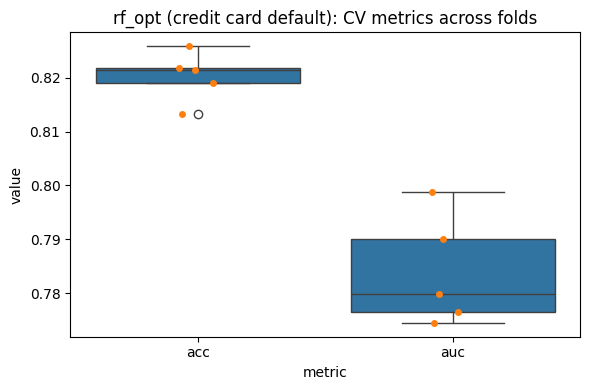

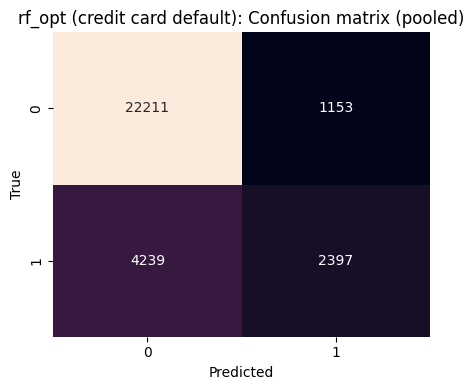

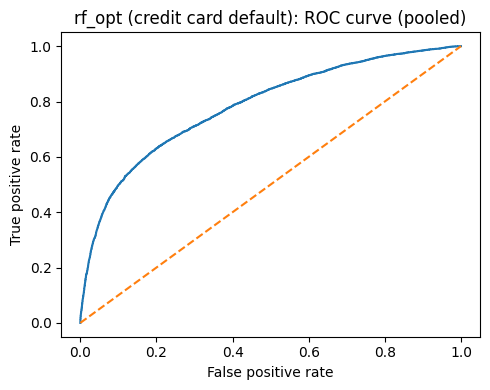

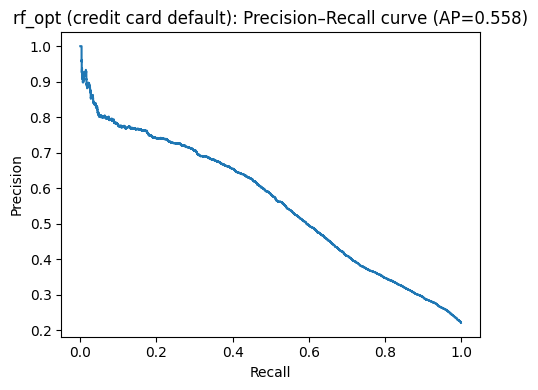

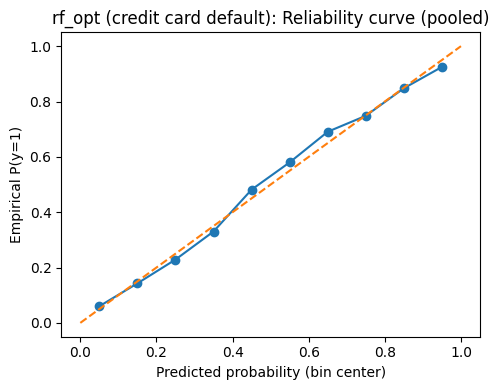


=== xgb_opt using xgb_optuna best params ===
{'n_estimators': 1266, 'max_depth': 6, 'learning_rate': 0.015272517294038042, 'subsample': 0.8668448958179759, 'colsample_bytree': 0.5382601104429133, 'min_child_weight': 13.587322682681727, 'gamma': 2.706564508733746, 'reg_lambda': 47.0602418705651, 'reg_alpha': 0.0005899418355558143, 'max_delta_step': 8}
xgb_opt Fold 1: ACC=0.8257 AUC=0.7930 | fit=0.882s pred=0.014s
xgb_opt Fold 2: ACC=0.8202 AUC=0.7812 | fit=0.928s pred=0.014s
xgb_opt Fold 3: ACC=0.8225 AUC=0.7993 | fit=0.881s pred=0.013s
xgb_opt Fold 4: ACC=0.8232 AUC=0.7764 | fit=0.881s pred=0.014s
xgb_opt Fold 5: ACC=0.8138 AUC=0.7804 | fit=0.895s pred=0.019s

xgb_opt 5-fold CV: ACC=0.8211±0.0045, AUC=0.7860±0.0097
Timing: fit=0.89s±0.02, predict=0.01s±0.00
-------------------------------------------------------


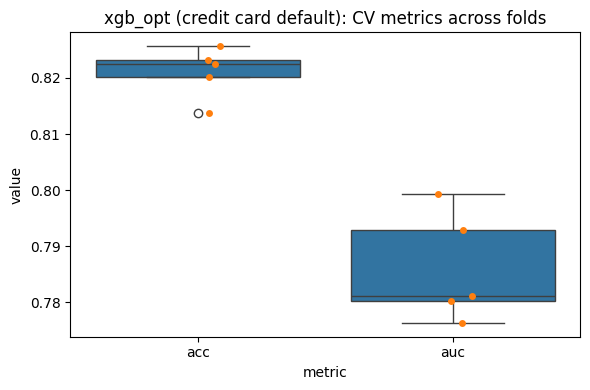

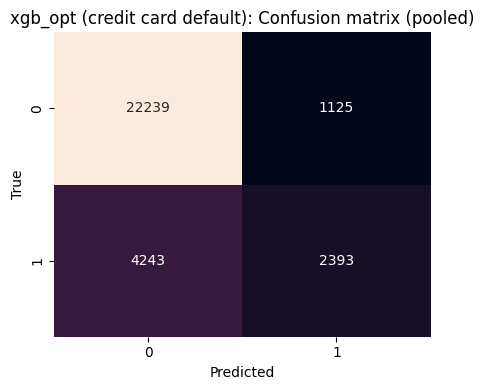

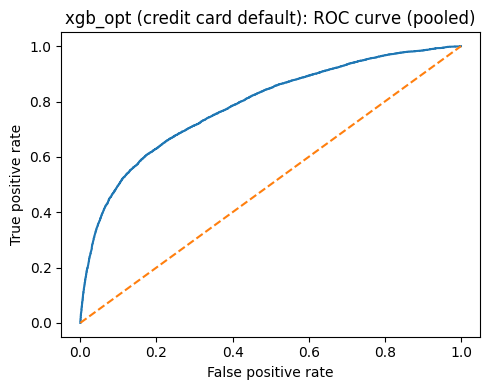

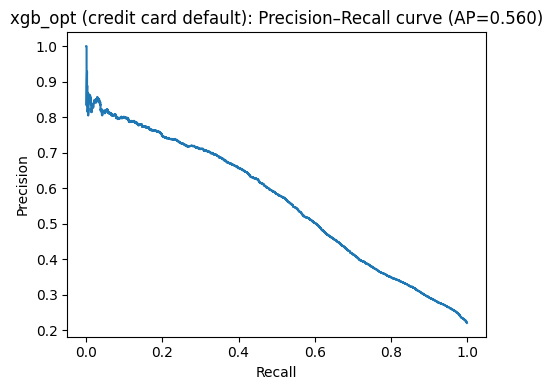

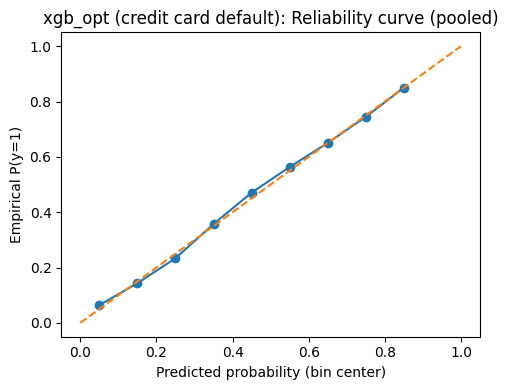


=== lgbm_opt using lgbm_optuna best params ===
{'n_estimators': 1311, 'learning_rate': 0.013423523523486015, 'num_leaves': 54, 'max_depth': -1, 'min_child_samples': 64, 'subsample': 0.9993357629109574, 'subsample_freq': 1, 'colsample_bytree': 0.5848706059126196, 'reg_lambda': 34.23242609208293, 'reg_alpha': 4.6914916757217264e-05, 'min_split_gain': 1.8936111489374696}
lgbm_opt Fold 1: ACC=0.8248 AUC=0.7916 | fit=0.853s pred=0.019s
lgbm_opt Fold 2: ACC=0.8215 AUC=0.7815 | fit=0.912s pred=0.021s
lgbm_opt Fold 3: ACC=0.8238 AUC=0.8000 | fit=0.907s pred=0.021s
lgbm_opt Fold 4: ACC=0.8242 AUC=0.7766 | fit=0.909s pred=0.022s
lgbm_opt Fold 5: ACC=0.8132 AUC=0.7801 | fit=0.962s pred=0.021s

lgbm_opt 5-fold CV: ACC=0.8215±0.0048, AUC=0.7860±0.0096
Timing: fit=0.91s±0.04, predict=0.02s±0.00
-------------------------------------------------------


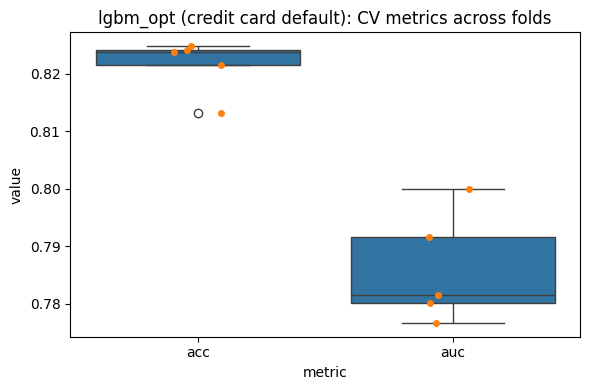

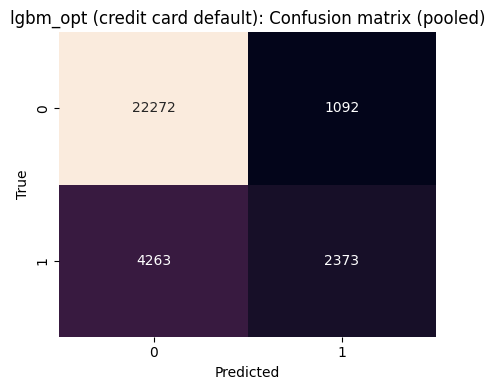

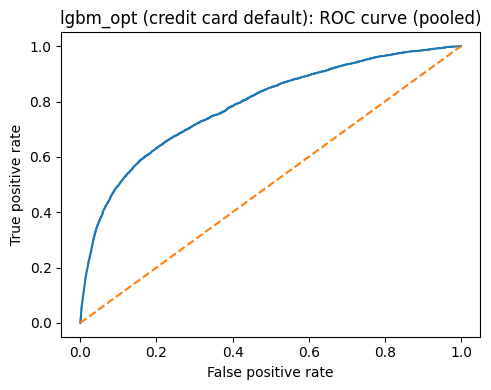

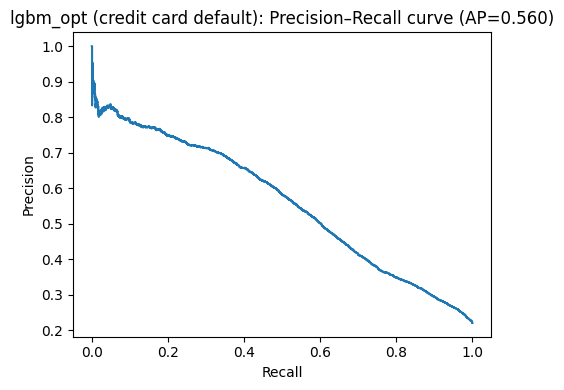

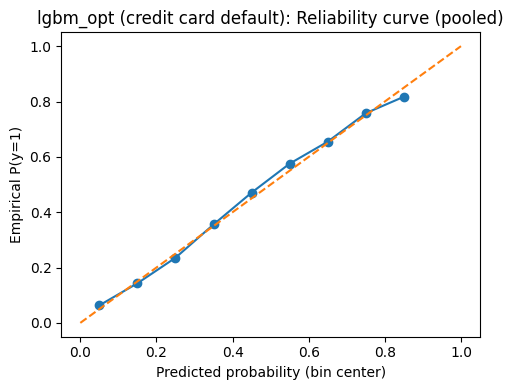


=== cat_opt using cat_optuna best params ===
{'iterations': 2460, 'depth': 8, 'learning_rate': 0.010142963459714034, 'l2_leaf_reg': 194.59295041704306, 'random_strength': 1.69746565168888, 'bagging_temperature': 1.3200203786936402, 'rsm': 0.6484149017082976, 'border_count': 172}
cat_opt Fold 1: ACC=0.8263 AUC=0.7919 | fit=38.471s pred=0.007s
cat_opt Fold 2: ACC=0.8212 AUC=0.7811 | fit=40.099s pred=0.007s
cat_opt Fold 3: ACC=0.8225 AUC=0.7994 | fit=41.473s pred=0.008s
cat_opt Fold 4: ACC=0.8225 AUC=0.7763 | fit=40.250s pred=0.007s
cat_opt Fold 5: ACC=0.8135 AUC=0.7797 | fit=40.514s pred=0.007s

cat_opt 5-fold CV: ACC=0.8212±0.0047, AUC=0.7857±0.0097
Timing: fit=40.16s±1.09, predict=0.01s±0.00
-------------------------------------------------------


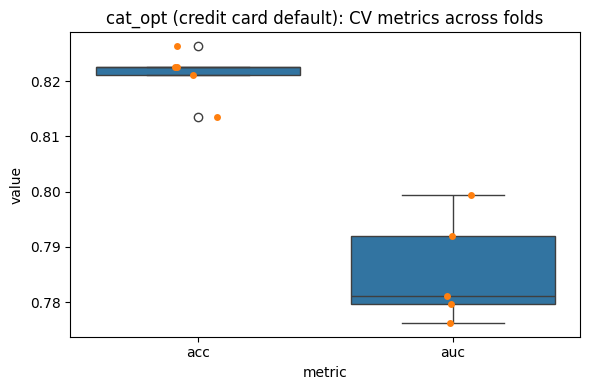

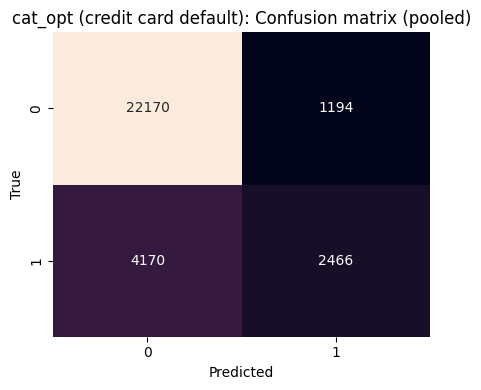

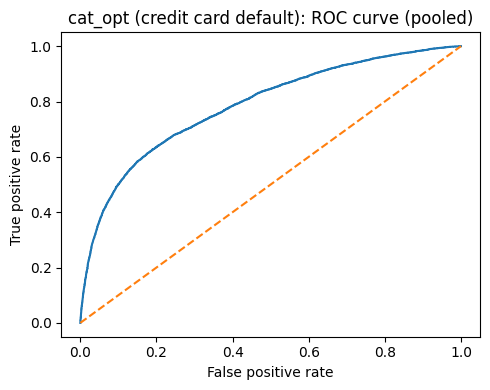

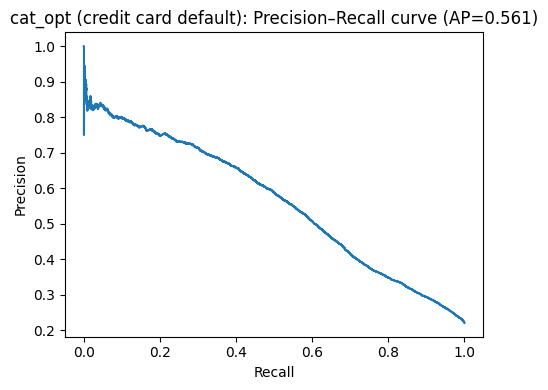

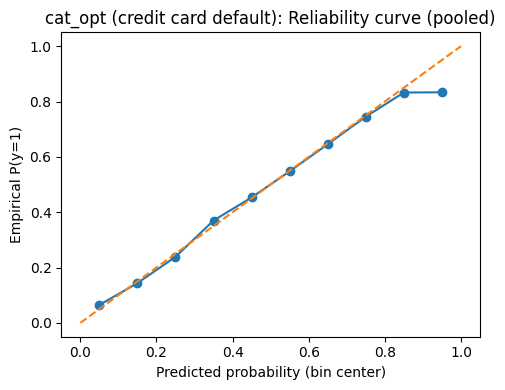

In [26]:
opt_models = {
    "rf_opt":  ("rf_optuna",  lambda p: RandomForestClassifier(random_state=20, n_jobs=-1, **p)),
    "xgb_opt": ("xgb_optuna", lambda p: XGBClassifier(
        random_state=20, n_jobs=-1, eval_metric="logloss", tree_method="hist", **p
    )),
    "lgbm_opt": ("lgbm_optuna", lambda p: LGBMClassifier(random_state=20, n_jobs=-1, verbose=-1, **p)),
    "cat_opt": ("cat_optuna", lambda p: CatBoostClassifier(random_seed=20, verbose=False, loss_function="Logloss", **p)),
}

for run_key, (opt_key, builder) in opt_models.items():
    if opt_key not in MODEL_RESULTS:
        print(f"Skipping {run_key}: missing MODEL_RESULTS['{opt_key}'] (run Optuna first).")
        continue

    best_params = dict(MODEL_RESULTS[opt_key]["best_params"])
    best_params.pop("use_scale_pos_weight", None)

    print(f"\n=== {run_key} using {opt_key} best params ===")
    print(best_params)

    run_cv(run_key, lambda bp=best_params: builder(bp))

    MODEL_RESULTS[run_key]["dataset"] = dataset_label
    plot_model_results(run_key)

In [27]:
rows = []
for name, res in MODEL_RESULTS.items():
    cv_df = res.get("cv_metrics_df", None)
    if cv_df is None or getattr(cv_df, "empty", True):
        continue
    if not {"acc", "auc"}.issubset(set(cv_df.columns)):
        continue

    rows.append({
        "model": name,
        "dataset": res.get("dataset", "unknown"),
        "acc_mean": cv_df["acc"].mean(),
        "acc_std": cv_df["acc"].std(ddof=1),
        "auc_mean": cv_df["auc"].mean(),
        "auc_std": cv_df["auc"].std(ddof=1),
        "fit_s_mean": cv_df["fit_s"].mean() if "fit_s" in cv_df.columns else np.nan,
        "pred_s_mean": cv_df["pred_s"].mean() if "pred_s" in cv_df.columns else np.nan,
        "n_folds": int(cv_df.shape[0]),
    })

summary_df = pd.DataFrame(rows)

for c in ["acc_mean", "acc_std", "auc_mean", "auc_std", "fit_s_mean", "pred_s_mean"]:
    if c in summary_df.columns:
        summary_df[c] = pd.to_numeric(summary_df[c], errors="coerce")

summary_df = summary_df.sort_values("auc_mean", ascending=False).reset_index(drop=True)

display(summary_df.style.format({
    "acc_mean": "{:.4f}",
    "acc_std": "{:.4f}",
    "auc_mean": "{:.4f}",
    "auc_std": "{:.4f}",
    "fit_s_mean": "{:.3f}",
    "pred_s_mean": "{:.3f}",
}))


,model,dataset,acc_mean,acc_std,auc_mean,auc_std,fit_s_mean,pred_s_mean,n_folds
0,tabpfn,credit card default,0.8202,0.0038,0.7897,0.0073,1.406,60.720,5
1,tabicl,credit card default,0.8200,0.0039,0.7881,0.0064,1.040,49.739,5
2,xgb_opt,credit card default,0.8211,0.0045,0.7860,0.0097,0.893,0.015,5
3,lgbm_opt,credit card default,0.8215,0.0048,0.7860,0.0096,0.909,0.021,5
4,cat_opt,credit card default,0.8212,0.0047,0.7857,0.0097,40.161,0.007,5
5,rf_opt,credit card default,0.8203,0.0046,0.7839,0.0102,3.484,0.142,5
6,cat,credit card default,0.8204,0.0043,0.7813,0.0112,7.072,0.006,5
7,lgbm,credit card default,0.8204,0.0044,0.7798,0.0095,0.139,0.005,5
8,rf,credit card default,0.8177,0.0039,0.7672,0.0082,3.179,0.141,5
9,xgb,credit card default,0.8147,0.0038,0.7651,0.0098,0.133,0.006,5


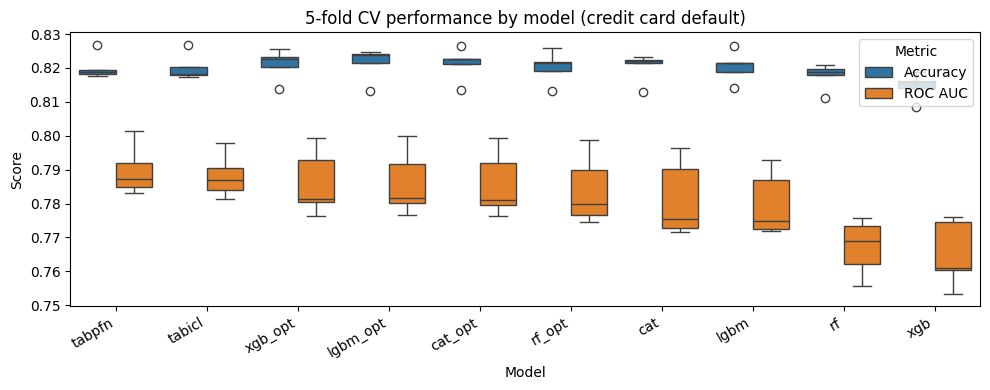

In [28]:
model_order = summary_df["model"].tolist()

rows = []
for name, res in MODEL_RESULTS.items():
    cv_df = res.get("cv_metrics_df")
    if cv_df is None or getattr(cv_df, "empty", True):
        continue
    if not {"fold", "acc", "auc"}.issubset(set(cv_df.columns)):
        continue

    tmp = cv_df.copy()
    tmp["model"] = name
    tmp["dataset"] = res.get("dataset", "unknown")
    rows.append(tmp)

cv_all = pd.concat(rows, ignore_index=True)

m_long = cv_all.melt(
    id_vars=["dataset", "model", "fold"],
    value_vars=["acc", "auc"],
    var_name="metric",
    value_name="value",
)

metric_names = {"acc": "Accuracy", "auc": "ROC AUC"}
m_long["metric"] = m_long["metric"].map(metric_names)

m_long["model"] = pd.Categorical(m_long["model"], categories=model_order, ordered=True)
m_long = m_long.sort_values("model")

plt.figure(figsize=(max(10, 0.7 * len(model_order)), 4))
ax = sns.boxplot(data=m_long, x="model", y="value", hue="metric", order=model_order)

ax.set_xlabel("Model")
ax.set_ylabel("Score")
datasets = ", ".join(sorted(m_long["dataset"].unique()))
ax.set_title(f"5-fold CV performance by model ({datasets})")

ax.legend(title="Metric", loc="upper right", frameon=True)

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


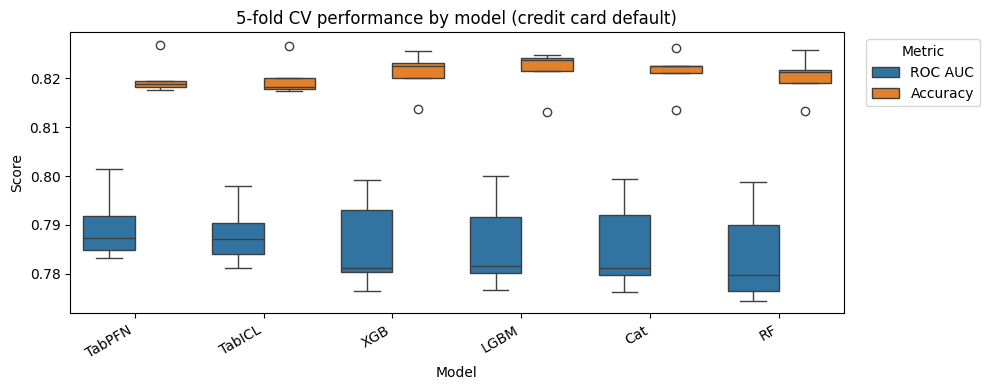

In [29]:
names = {
    "tabicl": "TabICL",
    "tabpfn": "TabPFN",
    "rf_opt": "RF",
    "xgb_opt": "XGB",
    "lgbm_opt": "LGBM",
    "cat_opt": "Cat",
}

wanted_keys = ["tabicl", "tabpfn", "cat_opt", "xgb_opt", "lgbm_opt", "rf_opt"]
present_keys = [k for k in wanted_keys if k in MODEL_RESULTS]

rows = []
for key in present_keys:
    res = MODEL_RESULTS[key]
    cv_df = res.get("cv_metrics_df")
    if cv_df is None or getattr(cv_df, "empty", True):
        continue
    if not {"fold", "acc", "auc"}.issubset(set(cv_df.columns)):
        continue

    tmp = cv_df.copy()
    tmp["model"] = names[key]
    tmp["dataset"] = res.get("dataset", "unknown")
    tmp["_key"] = key
    rows.append(tmp)

cv_all = pd.concat(rows, ignore_index=True)

auc_rank = (
    cv_all.groupby("_key")["auc"]
    .mean()
    .sort_values(ascending=False)
)

present_keys_ranked = [k for k in auc_rank.index.tolist() if k in present_keys]
model_order = [names[k] for k in present_keys_ranked]

m_long = cv_all.melt(
    id_vars=["dataset", "model", "fold", "_key"],
    value_vars=["acc", "auc"],
    var_name="metric",
    value_name="value",
)

metric_order = ["auc", "acc"]
metric_names = {"acc": "Accuracy", "auc": "ROC AUC"}

m_long["metric"] = pd.Categorical(m_long["metric"], categories=metric_order, ordered=True)
m_long["metric"] = m_long["metric"].map(metric_names)

m_long["model"] = pd.Categorical(m_long["model"], categories=model_order, ordered=True)
m_long = m_long.sort_values(["model", "metric"])

plt.figure(figsize=(max(10, 0.7 * len(model_order)), 4))
ax = sns.boxplot(
    data=m_long,
    x="model",
    y="value",
    hue="metric",
    order=model_order,
    hue_order=[metric_names[m] for m in metric_order],
)

ax.set_xlabel("Model")
ax.set_ylabel("Score")
datasets = ", ".join(sorted(m_long["dataset"].unique()))
ax.set_title(f"5-fold CV performance by model ({datasets})")

ax.legend(title="Metric", loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=True)

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()
